In [267]:
import pulp as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [268]:
## DATA
regions = ["A", "B", "C", "D", "E", "F"]
schools = ["S1", "S2", "S3"]
grades_list = ["6", "7", "8"]

In [269]:
## ENROLLMENT BY REGION AND GRADE
grades = {
    "A": {"6": 144, "7": 171, "8": 135},
    "B": {"6":222,"7":168,"8":210},
    "C": {"6":165,"7":176,"8":209},
    "D": {"6":98 ,"7":140,"8":112},
    "E": {"6":195,"7":170,"8":135},
    "F": {"6":153,"7":126,"8":171},
}
n_region = {r: sum(grades[r][g] for g in grades_list) for r in regions}

In [270]:
## CAPACITIES
capacity = {"S1":900,"S2":1100,"S3":1100}

In [271]:
## COST MATRIX
# $0 = <1mi; $200 = 1-1.5mi; $300 = 1.5-2mi; $100 per extra 0.5mi
# None = infeasible link
base_cost = {
    ("A","S1"):300, ("A","S2"):0,   ("A","S3"):700,
    ("B","S1"):None,("B","S2"):400, ("B","S3"):500,
    ("C","S1"):600, ("C","S2"):300, ("C","S3"):200,
    ("D","S1"):200, ("D","S2"):500, ("D","S3"):None,
    ("E","S1"):0,   ("E","S2"):None,("E","S3"):400,
    ("F","S1"):500, ("F","S2"):300, ("F","S3"):0,
}

In [272]:
## DISTRICT & REGION GRADE SHARES
n_region = {}
for r in regions:
    n_region[r] = sum(grades[r][g] for g in grades_list)

p_rg = {}
for r in regions:
    for g in grades_list:
        p_rg[(r, g)] = grades[r][g] / n_region[r]

In [273]:
## POLICY COST MATRICES
def option_costs(option):
    """
    Option 1: continue bussing all students living >1 mile –> base costs as given
    Option 2: stop bussing students traveling 1-1.5miles –> convert $200 –> $0
    Option 3: stop bussing students traveling 1-2miles –> convert $200, $300 –> $0
    """
    costs = {}
    for (r, s), c in base_cost.items():
        if c is None:
            continue
        if option == 3 and c in (200, 300):
            c0 = 0
        elif option == 2 and c == 200:
            c0 = 0
        else:
            c0 = c
        costs[(r, s)] = c0
    return costs  # keys here are the feasible links


In [279]:
#SOLVER
def solve_option(option):
    costs = option_costs(option)
    feas = list(costs.keys())

    # x[r,s] = integer students from region r to school s
    prob = pl.LpProblem(f"Option_{option}", pl.LpMinimize)
    x = {}
    for (r, s) in feas:
        x[(r, s)] = pl.LpVariable(f"x_{r}_{s}", lowBound=0, cat=pl.LpInteger)

    # total at each school
    y = {}
    for s in schools:
        y[s] = pl.lpSum(x[(r, s)] for r in regions if (r, s) in x)

    # objective: min transportation cost
    prob += pl.lpSum(costs[(r, s)] * x[(r, s)] for (r, s) in feas)

    # each region fully assigned
    for r in regions:
        prob += pl.lpSum(x[(r, s)] for s in schools if (r, s) in x) == n_region[r]

    # school capacities
    for s in schools:
        prob += y[s] <= capacity[s]

     # --- PROPOSED ADDITIONAL CONSTRAINT: COMMENT OUT THIS LOOP TO SEE INITIAL PROCESS ---
    for r in regions:
        if r == "B":
            continue  # exempt
        has_walk = any((r, s) in x and costs[(r, s)] == 0 for s in schools)
        if has_walk:
            prob += pl.lpSum(
                x[(r, s)] for s in schools
                if (r, s) in x and costs[(r, s)] == 0
            ) >= 0.5 * n_region[r]

    # grade mix 31–34% at each school
    for s in schools:
        for g in grades_list:
            lhs = pl.lpSum(p_rg[(r, g)] * x[(r, s)] for r in regions if (r, s) in x)
            prob += lhs >= 0.31 * y[s]
            prob += lhs <= 0.35 * y[s]

  
    # solve
    status = prob.solve(pl.PULP_CBC_CMD(msg=False))
    if pl.LpStatus[status] != "Optimal":
       raise RuntimeError(f"Option {option} not optimal: {pl.LpStatus[status]}")

    # pull out solution
    X = {(r, s): int(pl.value(x[(r, s)])) for (r, s) in feas}
    loads = {}
    for s in schools:
        loads[s] = sum(X.get((r, s), 0) for r in regions)

    # grade shares per school
    shares = {s: {g: 0.0 for g in grades_list} for s in schools}
    for s in schools:
        if loads[s] == 0:
            continue
        for g in grades_list:
            count = 0.0
            for r in regions:
                if (r, s) in X:
                    count += p_rg[(r, g)] * X[(r, s)]
            shares[s][g] = count / loads[s]

    total_cost = float(pl.value(prob.objective))
    return {"option": option, "cost": total_cost, "loads": loads, "shares": shares, "assignments": X}


In [280]:
# STORE RESULTS
results = [solve_option(opt) for opt in (1, 2, 3)]

In [281]:
for res in results:
    print(f"\n=== Option {res['option']} ===")
    print(f"Total cost: ${res['cost']:,.0f}")
    for s in schools:
        sh = res["shares"][s]
        print(
            f" {s}: load {res['loads'][s]:4d}/{capacity[s]} | "
            f"6={sh['6']*100:4.1f}%  7={sh['7']*100:4.1f}%  8={sh['8']*100:4.1f}%"
        )

    # simple table: rows = regions, cols = schools
    X = res["assignments"]
    df = pd.DataFrame({s: [X.get((r, s), 0) for r in regions] for s in schools},
                      index=regions)
    print("\nAssignments (rows=regions, cols=schools):")
    print(df.to_string())


=== Option 1 ===
Total cost: $646,200
 S1: load  816/900 | 6=33.0%  7=35.0%  8=32.0%
 S2: load 1100/1100 | 6=34.2%  7=32.5%  8=33.3%
 S3: load  984/1100 | 6=33.8%  7=31.2%  8=35.0%

Assignments (rows=regions, cols=schools):
    S1   S2   S3
A    0  450    0
B    0  525   75
C    0  125  425
D  350    0    0
E  252    0  248
F  214    0  236

=== Option 2 ===
Total cost: $488,200
 S1: load  815/900 | 6=33.0%  7=35.0%  8=32.0%
 S2: load 1099/1100 | 6=34.6%  7=32.1%  8=33.3%
 S3: load  986/1100 | 6=33.2%  7=31.8%  8=35.0%

Assignments (rows=regions, cols=schools):
    S1   S2   S3
A    0  424   26
B    0  600    0
C    0   65  485
D  350    0    0
E  250    0  250
F  215   10  225

=== Option 3 ===
Total cost: $437,900
 S1: load  896/900 | 6=33.5%  7=35.0%  8=31.5%
 S2: load 1100/1100 | 6=33.6%  7=32.5%  8=34.0%
 S3: load  904/1100 | 6=34.0%  7=31.0%  8=35.0%

Assignments (rows=regions, cols=schools):
    S1   S2   S3
A    5  445    0
B    0  293  307
C    0  116  434
D  350    0    0
E 

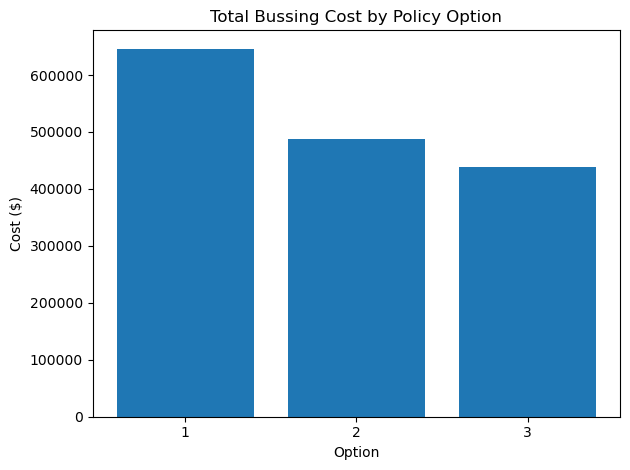

In [282]:
# 1) Total cost by option
plt.figure()
plt.bar([str(r["option"]) for r in results], [r["cost"] for r in results])
plt.title("Total Bussing Cost by Policy Option")
plt.xlabel("Option")
plt.ylabel("Cost ($)")
plt.tight_layout()
plt.show()

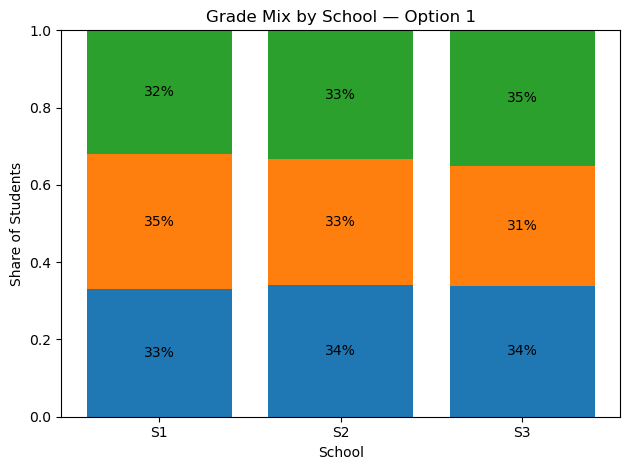

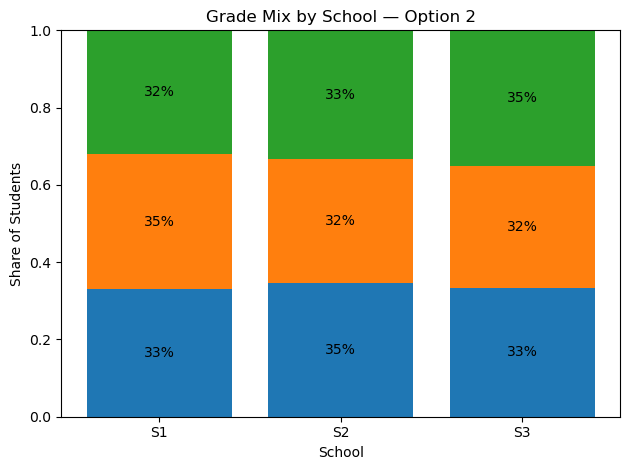

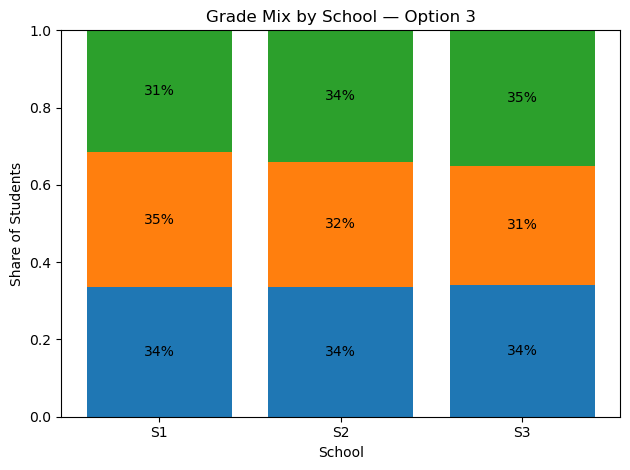

In [283]:

# 2) Grade mix per school (stacked, with % labels) for each option
for res in results:
    plt.figure()
    # heights for S1,S2,S3
    h6 = np.array([res["shares"][s]["6"] for s in schools], dtype=float)
    h7 = np.array([res["shares"][s]["7"] for s in schools], dtype=float)
    h8 = np.array([res["shares"][s]["8"] for s in schools], dtype=float)

    bottom = np.zeros(len(schools), dtype=float)
    for heights in (h6, h7, h8):
        bars = plt.bar(schools, heights, bottom=bottom)
        # label each bar segment with its percent
        for i, b in enumerate(bars):
            if heights[i] > 0:
                plt.text(
                    b.get_x() + b.get_width() / 2.0,
                    bottom[i] + heights[i] / 2.0,
                    f"{heights[i]*100:.0f}%",
                    ha="center",
                    va="center",
                )
        bottom += heights

    plt.title(f"Grade Mix by School — Option {res['option']}")
    plt.xlabel("School")
    plt.ylabel("Share of Students")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()